In [165]:
import numpy as np
import gensim
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Embedding, Flatten, merge
from keras.optimizers import Adam
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot
from keras.utils.visualize_util import model_to_dot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
import pickle
import pandas as pd

In [166]:
corpora = gensim.corpora.Dictionary.load('./data/corpora.dat')
vocab_size = len(corpora)
print('Number of words in corpora: %d'%(vocab_size))

Number of words in corpora: 26


In [167]:
tmp = list(corpora.items())

In [168]:
#the_filename = './data/wonderland.txt.dat'
the_filename = './data/test.txt.dat'
with open(the_filename, 'rb') as f:
    text = pickle.load(f)

### Generate words patterns - 2 words model

In [169]:
cs = 2
c1_dat = [text[i] for i in range(0, len(text)-cs, cs)]
c2_dat = [text[i+1] for i in range(0, len(text)-cs, cs)]
c3_dat = [text[i+2] for i in range(0, len(text)-cs, cs)]

In [170]:
tmp1 = [corpora.id2token[id] for id in c1_dat]
tmp2 = [corpora.id2token[id] for id in c2_dat]
tmp3 = [corpora.id2token[id] for id in c3_dat]
#tmp1, tmp2, tmp3

In [171]:
# inputs
x1 = np.stack(c1_dat[:])
x2 = np.stack(c2_dat[:])
# outputs
y = np.stack(c3_dat[:])

In [172]:
x1, x2, y

(array([ 2,  4,  3,  5,  7, 10, 13, 15, 16, 18, 10, 21, 20, 21]),
 array([ 0,  8,  6,  9,  1, 12, 11, 17, 19, 14, 22, 23, 25, 23]),
 array([ 4,  3,  5,  7, 10, 13, 15, 16, 18, 10, 21, 20, 21, 24]))

In [173]:
x1.shape, x2.shape, y.shape

((14,), (14,), (14,))

#### The number of latent factors to create (i.e. the size of the embedding matrix)

In [174]:
n_fac = 4

#### Create inputs and embedding outputs for each of our 3 character inputs

In [175]:
def embedding_input(name, n_in, n_out):
    inp = Input(shape=(1,), dtype='int64', name=name)
    emb = Embedding(n_in, n_out, input_length=1)(inp)
    return inp, Flatten()(emb)

In [176]:
c1_in, c1 = embedding_input('c1', vocab_size, n_fac)
c2_in, c2 = embedding_input('c2', vocab_size, n_fac)

In [177]:
n_hidden = 256

In [178]:
dense_in = Dense(n_hidden, activation='relu')

In [179]:
c1_hidden = dense_in(c1)

In [180]:
dense_hidden = Dense(n_hidden, activation='tanh')

In [181]:
c2_dense = dense_in(c2)
hidden_2 = dense_hidden(c1_hidden)
c2_hidden = merge([c2_dense, hidden_2])

In [182]:
dense_out = Dense(vocab_size, activation='softmax')

In [183]:
c3_out = dense_out(c2_hidden)

In [184]:
model = Model([c1_in, c2_in], c3_out)

In [185]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [186]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
c1 (InputLayer)                  (None, 1)             0                                            
____________________________________________________________________________________________________
c2 (InputLayer)                  (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_11 (Embedding)         (None, 1, 4)          104         c1[0][0]                         
____________________________________________________________________________________________________
embedding_12 (Embedding)         (None, 1, 4)          104         c2[0][0]                         
___________________________________________________________________________________________

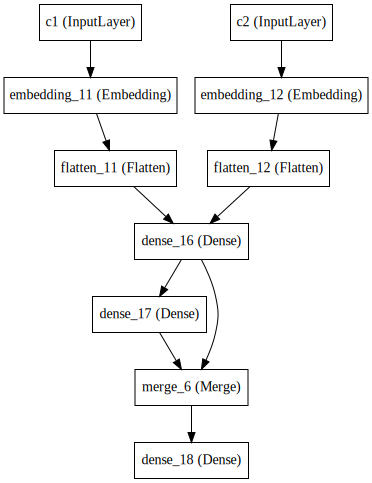

In [187]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [188]:
# checkpoint
filepath="dev_fast_ai_simple_model_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

In [189]:
#model.optimizer.lr = 0.000001
model.fit([x1, x2], y, batch_size=2, nb_epoch=100, callbacks=[checkpoint])

Epoch 1/100
14/14 [==============================] - 0s - loss: 3.2648 - acc: 0.0000e+00     
Epoch 2/100
14/14 [==============================] - 0s - loss: 3.2140 - acc: 0.0714     
Epoch 3/100
14/14 [==============================] - 0s - loss: 3.1552 - acc: 0.2143     
Epoch 4/100
14/14 [==============================] - 0s - loss: 3.0697 - acc: 0.3571     
Epoch 5/100
14/14 [==============================] - 0s - loss: 2.9419 - acc: 0.1429     
Epoch 6/100
14/14 [==============================] - 0s - loss: 2.7765 - acc: 0.1429     
Epoch 7/100
14/14 [==============================] - 0s - loss: 2.5706 - acc: 0.2857     
Epoch 8/100
14/14 [==============================] - 0s - loss: 2.3788 - acc: 0.2857     
Epoch 9/100
14/14 [==============================] - 0s - loss: 2.2517 - acc: 0.2857     
Epoch 10/100
14/14 [==============================] - 0s - loss: 2.1360 - acc: 0.2857     
Epoch 11/100
14/14 [==============================] - 0s - loss: 2.0222 - acc: 0.2857     
Epoc

In [190]:
# summarize performance of the model
scores = model.evaluate([x1, x2], y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Accuracy: 92.86%


In [191]:
model.save('./models/dev_fast_ai_simple_model.h5')

## Test model

In [199]:
# Reload weights
model.load_weights(filepath)

In [200]:
def get_next_multi(inp):
    idxs = [corpora.token2id[c] for c in inp]
    print(idxs)
    arrs = [np.array(i)[np.newaxis] for i in idxs]
    print(arrs)
    
    p = model.predict(arrs)
    print(p.shape)
    i_max1 = np.argmax(p)
    p[0,i_max1] = 0
    i_max2 = np.argmax(p)
    p[0,i_max2] = 0
    i_max3 = np.argmax(p)

    
    return corpora.id2token[i_max1], corpora.id2token[i_max2], corpora.id2token[i_max3]

In [201]:
def get_next(inp):
    idxs = [corpora.token2id[c] for c in inp]
    #print(idxs)
    arrs = [np.array(i)[np.newaxis] for i in idxs]
    #print(arrs)
    
    p = model.predict(arrs)
    #print(p.shape)
    i_max1 = np.argmax(p)
    #p[0,i_max1] = 0
    #i_max2 = np.argmax(p)
    #p[0,i_max2] = 0
    #i_max3 = np.argmax(p)

    
    return corpora.id2token[i_max1]#, corpora.id2token[i_max2], corpora.id2token[i_max3]

In [202]:
get_next(['One', 'two'])

'three'

In [203]:
test_cases_text = pd.read_csv('./data/test_cases_text.csv')
pred = []
for index, row in test_cases_text.iterrows():
    #print( '%s %s'%(row['in_0'], row['in_1']))
    inp = [row['in_0'], row['in_1']]
    #print(inp)
    tmp = get_next(inp)
    pred.append(tmp)
test_cases_text['predicted'] = pred

In [204]:
test_cases_text[test_cases_text.out==test_cases_text.predicted]

,in_0,in_1,out,predicted
0,One,two,three,three
2,three,four,five,five
4,five,six,seven,seven
6,seven,eight,nine,nine
8,nine,ten,.,.
10,.,The,quick,quick
12,quick,brown,fox,fox
14,fox,jumps,over,over
16,over,a,lazy,lazy
18,lazy,dog,.,.


In [205]:
true_cnt = len(test_cases_text[test_cases_text.out==test_cases_text.predicted].index) * 1.0
all_cnt = len(test_cases_text.index) * 1.0
print('True cnt: %d All cnt %d'%(true_cnt, all_cnt))
print("Precision: %.2f"%( true_cnt/all_cnt))

True cnt: 13 All cnt 28
Precision: 0.46
